In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import json

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from bcnf.models.cnf import CondRealNVP
from bcnf.utils import get_dir
from bcnf.simulation.resimulation import resimulate
from bcnf.utils import load_config, load_data, sub_root_path

## Model

In [3]:
MODEL_NAME = f'videos_CNN_large_single'

In [4]:
with open(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), 'config.json'), 'r') as f:
    config = load_config(json.load(f)['config_path'])

cnf = CondRealNVP.from_config(config).to(device)

cnf.load_state_dict(torch.load(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), "state_dict.pt")))

cnf.eval();

[Sequential(
  (0): Conv2d(1, 8, kernel_size=(8, 8), stride=(1, 1), padding=(3, 3))
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
)]


In [5]:
print(f'Number of parameters: {cnf.n_params:,}')

Number of parameters: 67,683,407


In [6]:
parameter_selection = cnf.parameter_index_mapping.parameters

## Data

In [7]:
data = load_data(sub_root_path(config['data']['path']).replace('/train', '/test'), verbose=True)

Loading data from directory:   0%|          | 0/1 [00:00<?, ?it/s, file=fixed_data_render_2s_15FPS_5.pkl]

Loading data from directory: 100%|██████████| 1/1 [00:07<00:00,  7.11s/it, file=fixed_data_render_2s_15FPS_5.pkl]


In [8]:
X_list = data['videos']

In [9]:
X = np.array(X_list)
y = cnf.parameter_index_mapping.vectorize(data)

print(f'{X.shape=}')
print(f'{y.shape=}')

X.shape=(1000, 2, 30, 90, 160)
y.shape=(1000, 19)


In [10]:
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

print(f'{X_tensor.shape=}')
print(f'{y_tensor.shape=}')

X_tensor.shape=torch.Size([1000, 2, 30, 90, 160])
y_tensor.shape=torch.Size([1000, 19])


## Sampling

In [14]:
y_sampled = cnf.sample(X_tensor.shape[0],
                       y=X_tensor,
                       sigma=1,
                       batch_size=4,
                       output_device="cpu",
                       verbose=True).cpu().numpy()

Sampling: 100%|██████████| 251/251 [00:03<00:00, 70.10it/s]


In [15]:
print(f'{y_sampled.shape=}')

y_sampled.shape=(1000, 19)


In [41]:
print(y_sampled.shape)
print(y_sampled[0:10].shape)

(1000, 19)
(10, 19)


In [52]:
num = 12

print(config["global"]["parameter_selection"][num])

for i in range(10):
    print(y_sampled[i][13])
    print(y[i][13])



a_x
0.0008279984
0.0
-0.0013631246
-0.0
8.8228444e-05
0.0
0.0002719572
0.0
-0.00028616693
-0.0
-0.00012246388
0.0
-0.0005719674
0.0
-0.0003062128
0.0
3.548659e-05
-0.0
-0.0007162985
-0.0


## Error

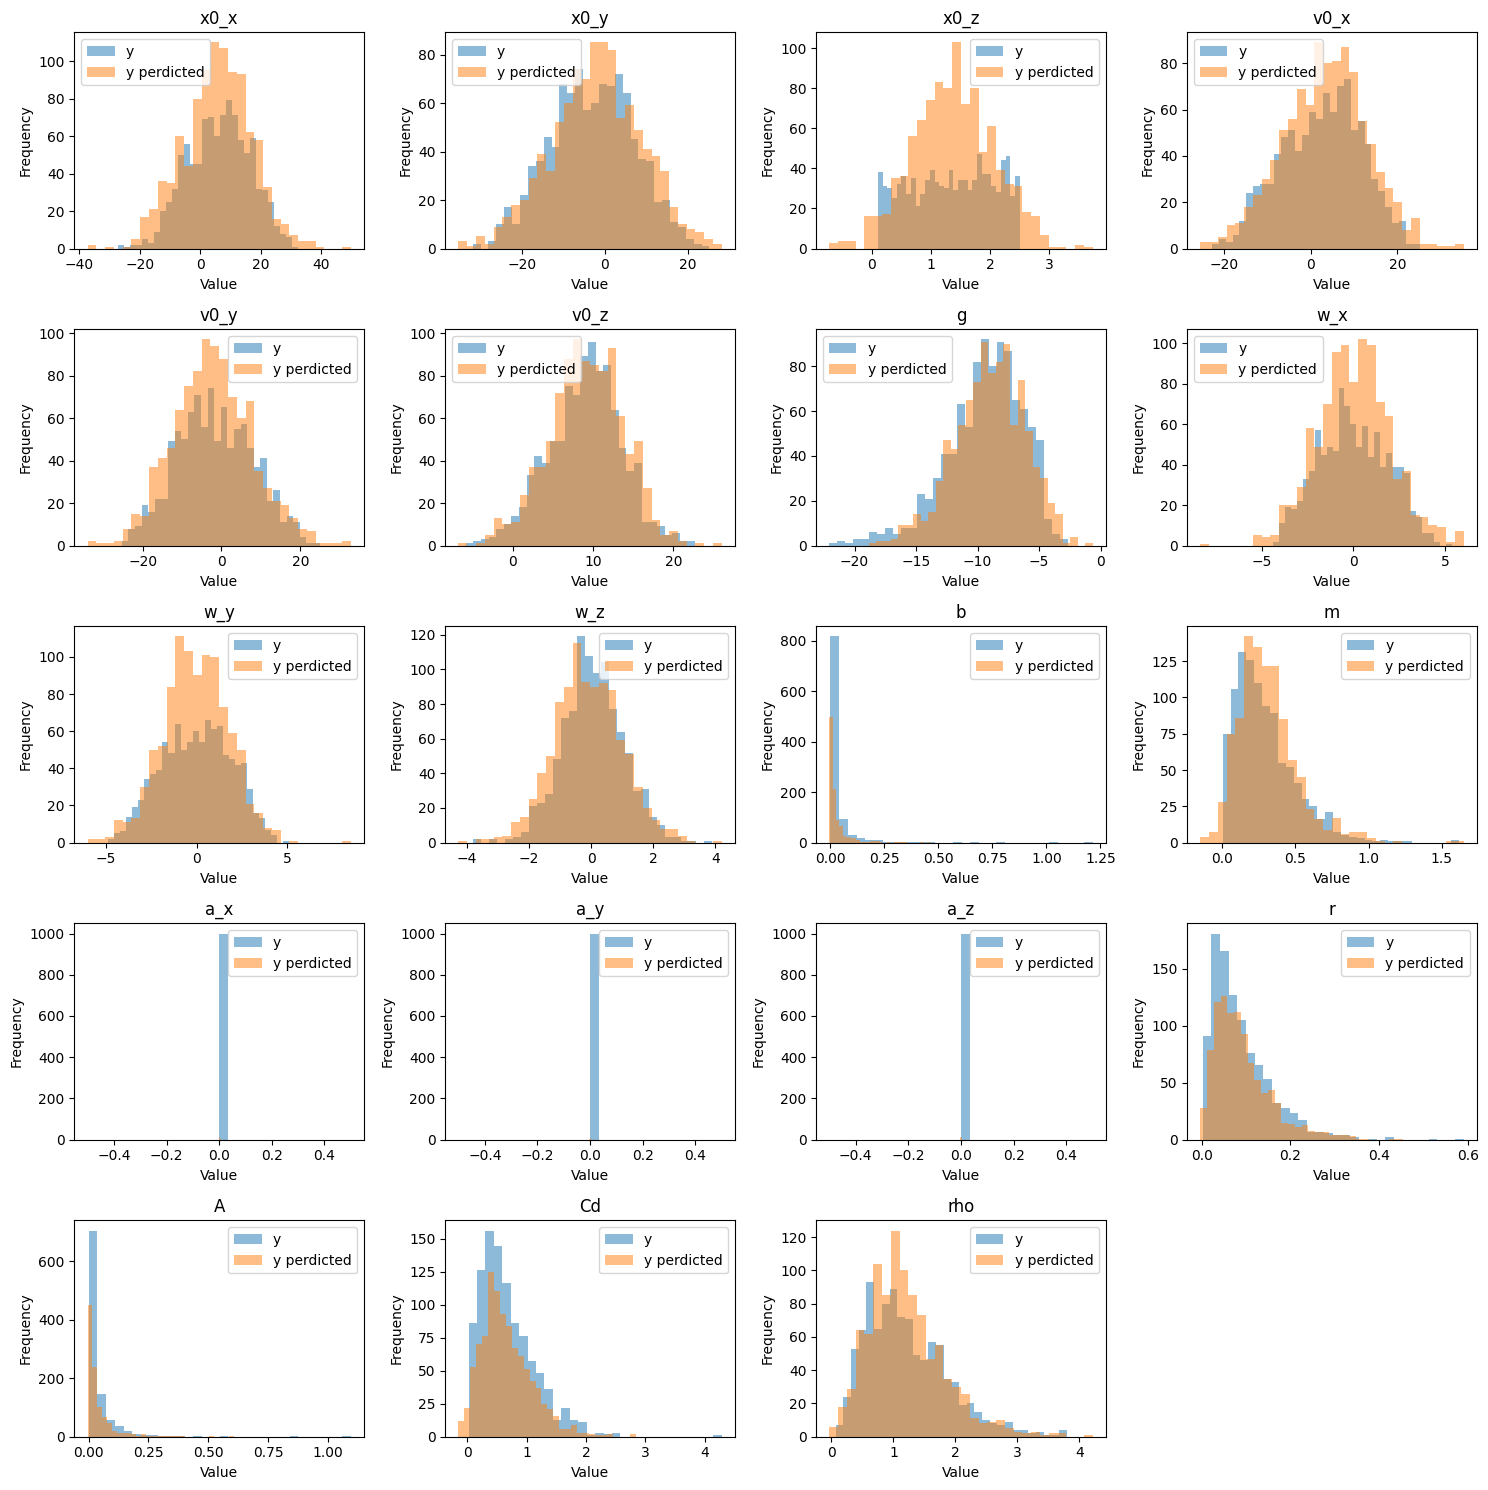

In [24]:
import numpy as np
import matplotlib.pyplot as plt

params = config["global"]["parameter_selection"]

bins = 30
alpha = 0.5
n_cols = 4  # number of columns in the subplot grid
n_rows = int(np.ceil(y.shape[1] / n_cols))  # calculate number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*3))  # create subplot grid

# Flatten the axes array, to make iterating over it easier
axes = axes.flatten()

# Histogram for y
for i in range(y.shape[1]):
    ax = axes[i]  # select the current axis
    ax.hist(y[:, i], bins=bins, alpha=alpha, label=f'y')
    ax.hist(y_sampled[:, i], bins=bins, alpha=alpha, label=f'y perdicted')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{params[i]}')
    ax.legend()

# Remove unused subplots
for i in range(y.shape[1], len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

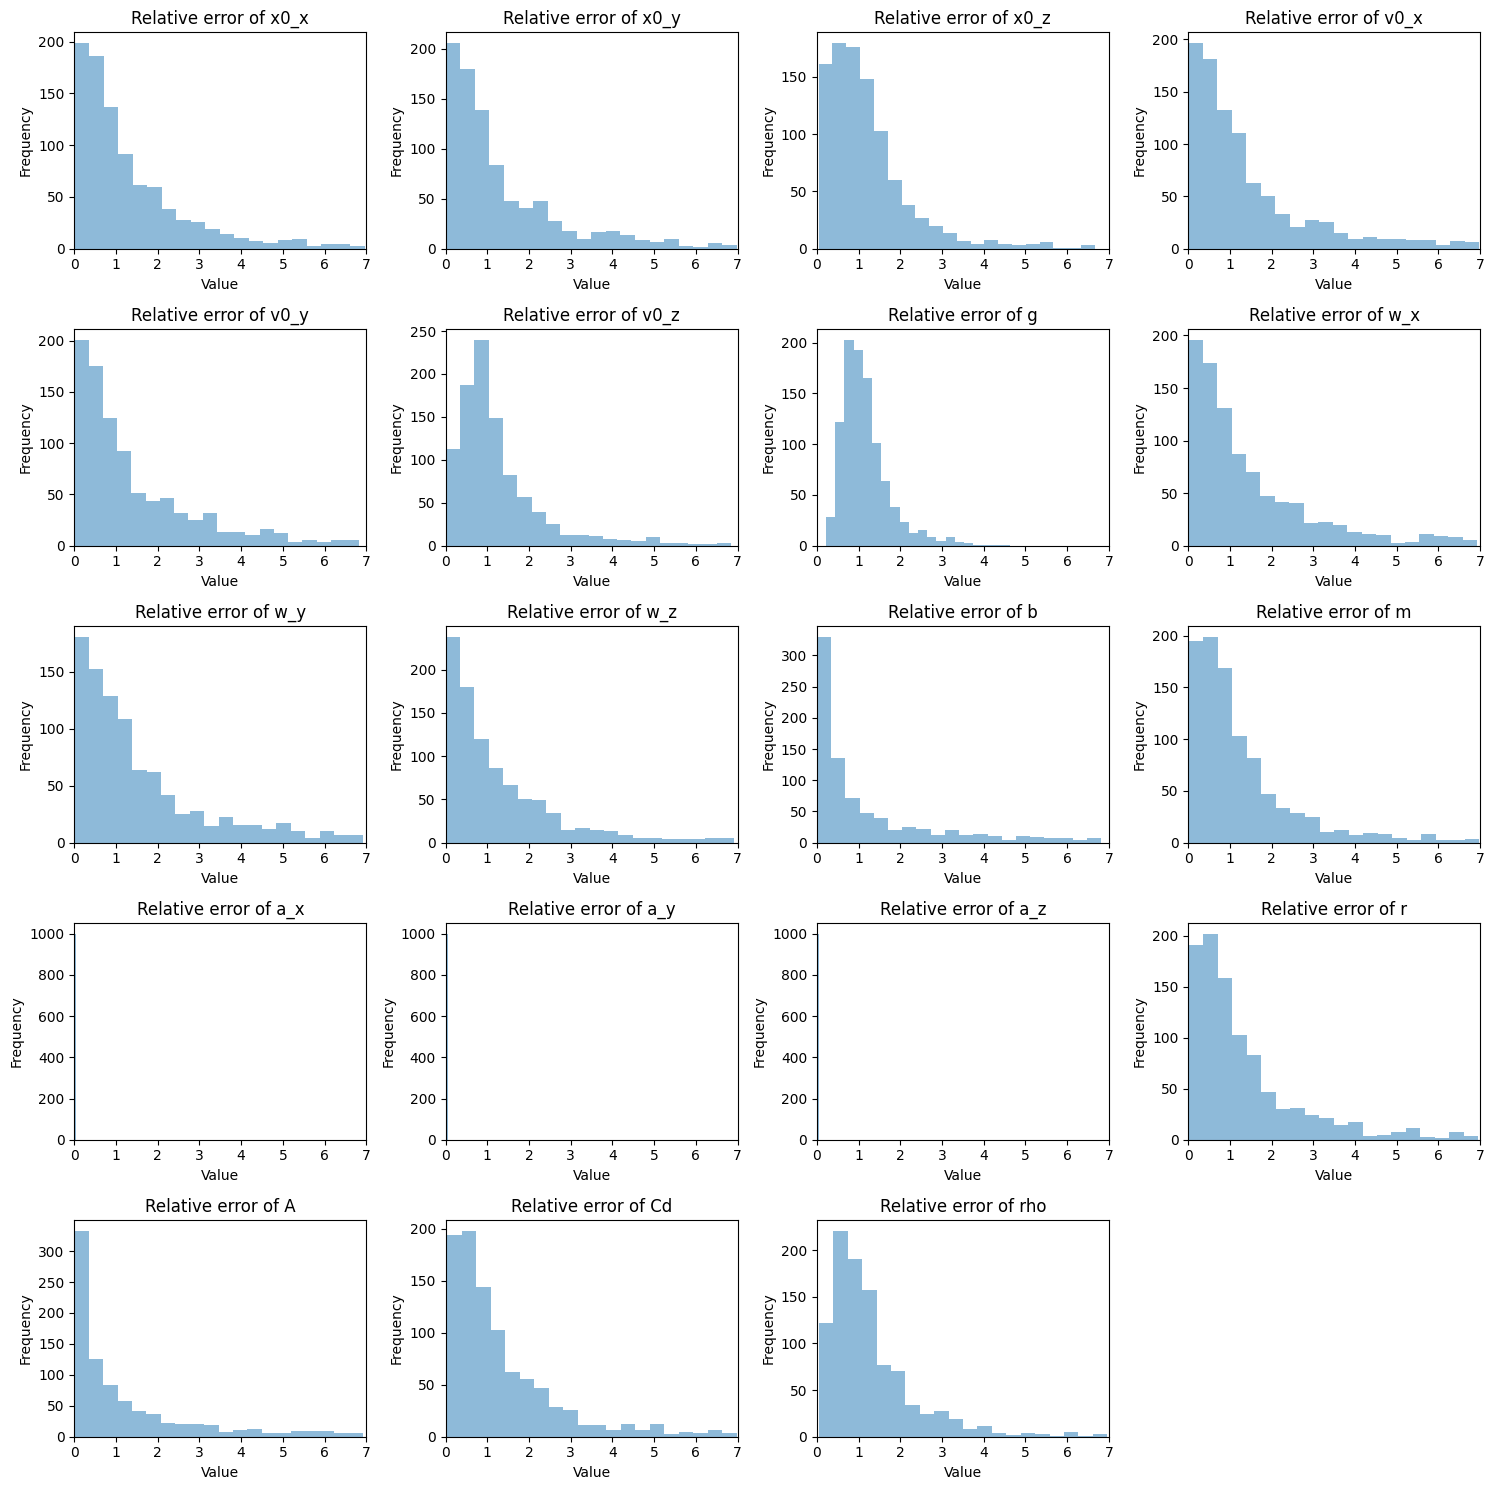

In [72]:
import numpy as np
import matplotlib.pyplot as plt

params = config["global"]["parameter_selection"]

bins = 20
alpha = 0.5
n_cols = 4  # number of columns in the subplot grid
n_rows = int(np.ceil(y.shape[1] / n_cols))  # calculate number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*3))  # create subplot grid

# Flatten the axes array, to make iterating over it easier
axes = axes.flatten()

# Calculate absolute relative difference
epsilon = 1e-7  # small constant
rel_error = np.abs(y / (y_sampled + epsilon))

# Histogram for absolute relative difference
for i in range(rel_error.shape[1]):
    ax = axes[i]  # select the current axis
    filtered_data = rel_error[:, i][rel_error[:, i] <= 7]  # filter data to only include values <= 5
    ax.hist(filtered_data, bins=bins, alpha=alpha, label=params[i])
    ax.set_xlim([0, 7])  # set x-axis limits
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Relative error of {params[i]}')

# Remove unused subplots
for i in range(rel_error.shape[1], len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()